Quick script to locate the inbound and outbound runs for wmaze in Can's data. 

This is not general and will need modification for other configs. 

In particular, Can's wmaze is oriented as an E, so well locations are adjusted accordingly. 



In [1]:
%reload_ext autoreload
%autoreload 2
from ripple_heterogeneity.utils import loading,functions,well_traversal_classification
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib
import nelpy as nel

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_w_maze_trajectories(
    position_df, max_distance_from_well=20, min_distance_traveled=50
):

    well_locations = np.array(
        [
            [
                position_df.query("states == 0").projected_x.max(),
                position_df.query("states == 0").projected_y.mean(),
            ],
            [
                position_df.query("states == 2").projected_x.max(),
                position_df.query("states == 2").projected_y.mean(),
            ],
            [
                position_df.query("states == 1").projected_x.max(),
                position_df.query("states == 1").projected_y.mean(),
            ],
        ]
    )

    temp_df = position_df[~np.isnan(position_df.x)]
    segments_df, _ = well_traversal_classification.segment_path(
        temp_df["timestamps"].values,
        temp_df[["projected_x", "projected_y"]].values,
        well_locations,
        max_distance_from_well=max_distance_from_well,
    )

    segments_df = well_traversal_classification.score_inbound_outbound(
        segments_df, min_distance_traveled=min_distance_traveled
    )
    conditions = [
        "from_well == 'Center' & to_well == 'Left'",
        "from_well == 'Left' & to_well == 'Center'",
        "from_well == 'Center' & to_well == 'Right'",
        "from_well == 'Right' & to_well == 'Center'",
    ]
    condition_labels = [
        "center_left",
        "left_center",
        "center_right",
        "right_center",
    ]
    trajectories = {}
    for con, con_label in zip(conditions, condition_labels):
        trajectories[con_label] = nel.EpochArray(
            np.array(
                [segments_df.query(con).start_time, segments_df.query(con).end_time]
            ).T
        )

    return trajectories, segments_df

In [18]:
basepath = r"Z:\Data\Can\OML23\day18"
epoch_df = loading.load_epoch(basepath)

beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])

position_df = loading.load_animal_behavior(basepath)

# remove nan values
bad_idx = np.isnan(position_df.linearized)
position_df = position_df[~bad_idx]

position_df

,time,x,y,linearized,units,nose_x_point,nose_1_y_point,midImplant_x_1_point,midImplant_1_y_1_point,leftEar_x_2_point,...,tailEnd_1_y_7_point,projected_x,projected_y,sr,timestamps,speed,acceleration,states,epochs,environment
0,7974.49270,139.060142,90.846256,273.250742,cm,NaN,NaN,1120.997681,732.333801,1129.324951,...,NaN,139.060142,112.110977,40.0,7974.49270,1.342916,0.000000,2.0,wmaze_220708_111934,wmaze
1,7974.51770,139.073074,90.815274,273.263674,cm,NaN,NaN,1121.101929,732.084045,1129.363159,...,NaN,139.073074,112.110977,40.0,7974.51770,0.779096,-0.563820,2.0,wmaze_220708_111934,wmaze
2,7974.54270,139.079403,90.812397,273.270003,cm,NaN,NaN,1121.152954,732.060852,1129.678345,...,NaN,139.079403,112.110977,40.0,7974.54270,0.156552,-0.622544,2.0,wmaze_220708_111934,wmaze
3,7974.56775,139.070560,90.822732,273.261160,cm,NaN,NaN,1121.081665,732.144165,1129.536743,...,NaN,139.070560,112.110977,40.0,7974.56775,1.131329,0.974777,2.0,wmaze_220708_111934,wmaze
4,7974.59275,139.035504,90.848066,273.226104,cm,NaN,NaN,1120.799072,732.348389,1129.551636,...,NaN,139.035504,112.110977,40.0,7974.59275,1.493247,0.361918,2.0,wmaze_220708_111934,wmaze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121112,22293.34780,154.182123,14.636744,280.004683,cm,1266.180054,129.130936,1242.899658,117.990356,1237.142090,...,NaN,144.702631,13.944776,40.0,22293.34780,7.204832,-1.150800,1.0,wmaze_220708_145428,wmaze
121113,22293.37280,154.230626,14.473097,280.004683,cm,1266.401733,129.261765,1243.290649,116.671158,1237.233643,...,NaN,144.702631,13.944776,40.0,22293.37280,6.936927,-0.267905,1.0,wmaze_220708_145428,wmaze
121114,22293.39785,154.309778,14.313855,280.004683,cm,1264.023438,128.227005,1243.928711,115.387474,1237.640259,...,NaN,144.702631,13.944776,40.0,22293.39785,8.757130,1.820203,1.0,wmaze_220708_145428,wmaze
121115,22293.42285,154.577837,14.206004,280.004683,cm,1265.791504,128.888443,1246.089600,114.518059,1239.130493,...,NaN,144.702631,13.944776,40.0,22293.42285,9.848390,1.091260,1.0,wmaze_220708_145428,wmaze


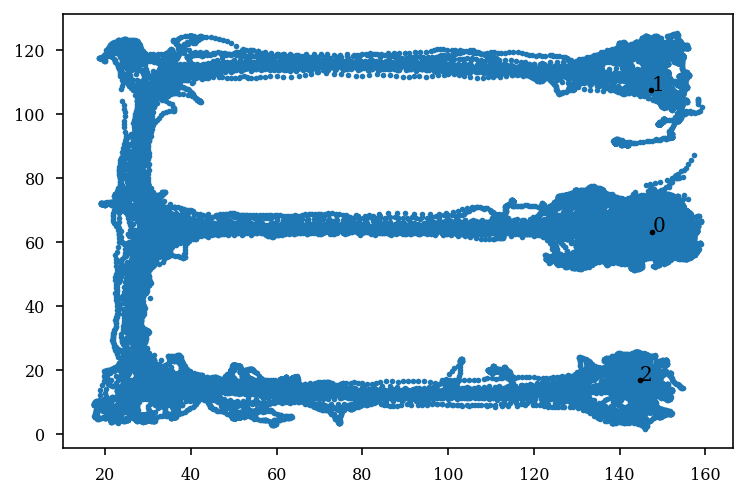

In [19]:
plt.plot(position_df.x, position_df.y, '.')


well_locations = np.array(
    [
        [
            position_df.query("states == 0").projected_x.max(),
            position_df.query("states == 0").projected_y.mean(),
        ],
        [
            position_df.query("states == 2").projected_x.max(),
            position_df.query("states == 2").projected_y.mean(),
        ],
        [
            position_df.query("states == 1").projected_x.max(),
            position_df.query("states == 1").projected_y.mean(),
        ],
    ]
)
for i, well_location in enumerate(well_locations):
    plt.plot(well_location[0], well_location[1], '.', color='k')
    plt.text(well_location[0], well_location[1], str(i))
# plt.scatter(well_locations[0,:], well_locations[1,:], color='r',s=100)

In [20]:
max_distance_from_well=20  # in cm, max distance from well to consider a well traversal
min_distance_traveled=50
trajectories,segments_df = get_w_maze_trajectories(
    position_df,
    max_distance_from_well=max_distance_from_well,
    min_distance_traveled=min_distance_traveled,
)
segments_df

,start_time,end_time,duration,from_well,to_well,distance_traveled,task,is_correct,turn
segment,,,,,,,,,
1,8018.37905,8020.90470,2.52565,Center,Right,237.215503,Outbound,True,Left
2,8035.03335,8045.46105,10.42770,Right,Center,267.350115,Inbound,True,Right
3,8066.56650,8069.39225,2.82575,Center,Right,238.708387,Outbound,False,Right
4,8072.16795,8086.24660,14.07865,Right,Center,283.470461,Inbound,True,Right
7,8108.20230,8110.70295,2.50065,Center,Left,240.280582,Outbound,True,Right
...,...,...,...,...,...,...,...,...,...
158,22015.55085,22024.37810,8.82725,Right,Left,297.659420,Inbound,False,Right
159,22026.77875,22029.27940,2.50065,Left,Center,240.357157,Inbound,True,Left
160,22044.95845,22047.48410,2.52565,Center,Right,236.706656,Outbound,True,Left


In [85]:
trajectories

{'center_left': <EpochArray at 0x24f3fdd4d00: 24 epochs> of length 1:23:196 minutes,
 'left_center': <EpochArray at 0x24f4a309e20: 23 epochs> of length 1:24:947 minutes,
 'center_right': <EpochArray at 0x24f4d833ca0: 29 epochs> of length 1:37:825 minutes,
 'right_center': <EpochArray at 0x24f4d361040: 30 epochs> of length 5:40:163 minutes}

In [21]:
trials = np.vstack(
    (
        [
            trajectories["center_left"].data,
            trajectories["left_center"].data,
            trajectories["center_right"].data,
            trajectories["right_center"].data,
        ]
    )
)
trialsID = np.hstack(
    [
        ["center_left"] * trajectories["center_left"].n_epochs,
        ["left_center"] * trajectories["left_center"].n_epochs,
        ["center_right"] * trajectories["center_right"].n_epochs,
        ["right_center"] * trajectories["right_center"].n_epochs,
    ]
)

sort_idx = np.argsort(trials[:,0])
trials = trials[sort_idx]
trialsID = trialsID[sort_idx]

In [22]:
import scipy.io as sio
import glob

filename = glob.glob(os.path.join(basepath,'*.animal.behavior.mat'))[0]

data = sio.loadmat(filename, simplify_cells=True)

data["behavior"]["trials"] = trials
data["behavior"]["trialsID"] = trialsID.astype(object)

sio.savemat(filename, data)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


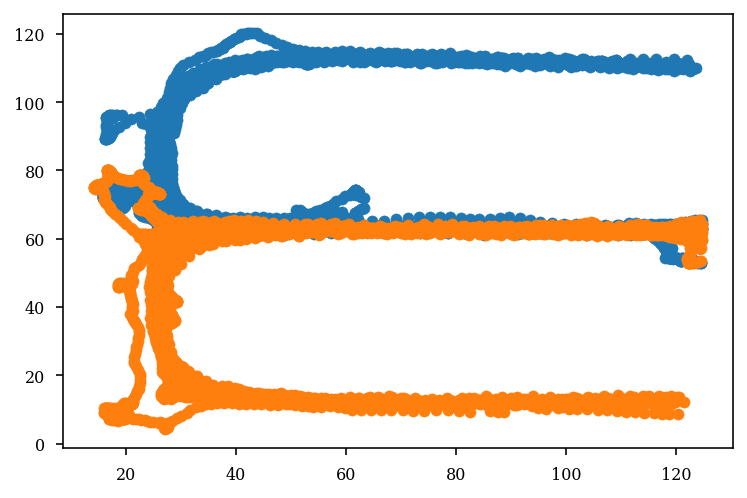

In [89]:
pos = nel.AnalogSignalArray(
    data=np.array(position_df[["x","y"]].values.T),
    timestamps=position_df.time,
    fs=position_df.sr.iloc[0],
)

plt.scatter(pos[trajectories["center_left"]].data[0],pos[trajectories["center_left"]].data[1])
plt.scatter(pos[trajectories["center_right"]].data[0],pos[trajectories["center_right"]].data[1])
# plt.scatter(pos[trajectories["left_center"]].data[0],pos[trajectories["left_center"]].data[1])
# plt.scatter(pos[trajectories["right_center"]].data[0],pos[trajectories["right_center"]].data[1])